In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

#Now to implement q learning and variants on the above market environment
import sys
if "../" not in sys.path:
  sys.path.append("../") 

from TD import GeneralQ, ExperienceQ, DynaQ 
from FA.model import TabularModel 
from Tabular import ExpTabAgent
from lib.envs.market import Market

%matplotlib inline

In [26]:
"""Important to store and set the different parameters

Experiment 1: Setup
mu 0.11, rf 0.10, sigma 0.028
M=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, 
u_star = np.linspace(-10,25, utes)

sims 300,000
kappa 0.008

eps greedy 0.1, learning rate 0.1, gamma 0.95
All the different models
do risk free and log utility based results, also show extreme risk aversion

(do we vary kappa?)


Experiment 2: Higher volatility - can it be learned?
mu 0.11, rf 0.10, sigma 0.1
M=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, 
u_star = np.linspace(-1,1.5, utes)

sims 300,000
kappa 0.007

eps greedy 0.1, learning rate 0.1, gamma 0.95

"""

'Important to store and set the different parameters\n\nExperiment 1: Setup\nmu 0.11, rf 0.10, sigma 0.028\nM=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, \nu_star = np.linspace(-10,25, utes)\n\nsims 300,000\nkappa 0.008\n\neps greedy 0.1, learning rate 0.1, gamma 0.95\nAll the different models\ndo risk free and log utility based results, also show extreme risk aversion\n\n(do we vary kappa?)\n\n\nExperiment 2: Higher volatility - can it be learned?\nmu 0.11, rf 0.10, sigma 0.1\nM=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, \nu_star = np.linspace(-1,1.5, utes)\n\nsims 300,000\nkappa 0.007\n\neps greedy 0.1, learning rate 0.1, gamma 0.95\n\n'

In [27]:
#################################################
# Stage 1 of my stuff is simply get a merton ration and sample paths 
# the maths (using stochastic optimal control will be described in the thesis)

#Set parameters
mu =0.11
rf = 0.10
sigma = 0.1
M = 20
time_periods = M
T = 1.0
dt = T/M
utes = 15
u_star = np.linspace(-1,2.5, utes) #this is specific to the above parameters

#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0
kappa = 0.006

gam=0.4

###########################copied params
"""
#Set parameters
mu =0.11 #save these paramters mu 0.11, rf 0.10, sigma 0.028
rf = 0.10
sigma = 0.028
sigma = 0.045

M = 20 #so 20 time periods or 50 still works...just longer to train and run, u_star = np.linspace(-10,25, utes)

time_periods = M
T = 1.0
dt = T/M
utes = 15
u_star = np.linspace(-10,25, utes) #this is specific to the above parameters
u_star = np.linspace(-10,10, utes)

#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0
"""

'\n#Set parameters\nmu =0.11 #save these paramters mu 0.11, rf 0.10, sigma 0.028\nrf = 0.10\nsigma = 0.028\nsigma = 0.045\n\nM = 20 #so 20 time periods or 50 still works...just longer to train and run, u_star = np.linspace(-10,25, utes)\n\ntime_periods = M\nT = 1.0\ndt = T/M\nutes = 15\nu_star = np.linspace(-10,25, utes) #this is specific to the above parameters\nu_star = np.linspace(-10,10, utes)\n\n#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided\n#wealth starts at 100\nS0 = 1\nB0 = 1\nX0 = 100\nwealth = X0\n'

In [28]:
def train_agent(kappa, model, episodes, exprep=0, gam=0.4):
    #main function to train the currently q learning tabular agents
    
    wealth = 100.0
    time_periods = M #from earlier on in the code

    utilities_mod = []
    rewards_mod = []
    wealth_episodes = []
    rsum = 0

    number_of_actions = utes #again from earlier in the code  
    number_of_states = 130 #when adjusting kappa I ran out of states

    start_state = int(wealth/10) #this is tied to wealth/ 10
    state =start_state #try int wealth for states

    gamma = 0.95
    learning_rate = 0.10
    egreedy = 0.1
    
    episodes = episodes #500k worked well? as did 1m
    Mark = Market(kappa, episodes, time_periods, mu, rf, sigma) #parameters from earlier
    
    if model==1:
        #Q learning no tabular model
        SARSA = False
        double = False
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    elif model==2:
        #Double Q learning no tabular model
        SARSA = False
        double = True
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    elif model==3:
        #Sarsa learning no tabular model
        SARSA = True
        double = False
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    elif model==4:
        #Double Sarsa learning no tabular model
        SARSA = True
        double = True
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
    
    elif model==5:
        #Experience replay tabular Q learning - just 5 replays for now...as it doesn't learn
        SARSA = False
        double = False
        
        agent = ExpTabAgent(number_of_states, number_of_actions, state,
                           SARSA, double, eps=egreedy, model=TabularModel, 
                            step_size=learning_rate, num_offline_updates=exprep)
        action = agent.behaviour(state)
    
    elif model==6:
        #Experience replay double tabular Q learning
        SARSA = False
        double = True
        
        agent = ExpTabAgent(number_of_states, number_of_actions, state,
                           SARSA, double, eps=egreedy, model=TabularModel, 
                            step_size=learning_rate, num_offline_updates=exprep)
        action = agent.behaviour(state)
    
    elif model==7:
        #Dyna Q learning
        SARSA = False
        
        agent = DynaQ(number_of_states, number_of_actions, state,
           model=TabularModel, num_offline_updates=exprep, step_size=0.1, eps=egreedy)
        
        action = agent.behaviour_policy(agent._q[state])
        
    #action = agent.behaviour_policy(agent._q[state]) #if dyna
    #action = agent.behaviour(state) #if exptab

    for i_episode in range(episodes-1):
        state = start_state

        while True:    
            prop = u_star[action]
            #reward, d, new_state, dx, done = Mark.step((prop, wealth))

            reward, _, _, dx, done = Mark.step((prop, wealth))
            

            wealth += dx
            new_state = int(wealth/10)

            action = agent.step(reward, gamma, new_state)

            #Q[state, action] = reward + gamma * torch.max(Q[new_state])
            #Q[state, action] = (1 - learning_rate) * Q[state, action] \
            #    + learning_rate * (reward + gamma * torch.max(Q[new_state])) #this is a simple torch implementation
            rsum += reward
            state = new_state

            if done:
                state = start_state
                agent._s = state

                if model == 5 or model == 6 :
                    agent._last_action = agent.behaviour(state)
                else:
                    action = agent.behaviour_policy(agent._q[state]) #if dyna
                    
                wealth_episodes.append(wealth)
                utilities_mod.append(np.power(wealth, gam))
                rewards_mod.append(rsum)
                rsum = 0
                wealth = 100.0
                break 
    
    #store the q_values for later testing
    #q_name = str(model)+'epi'+str(episodes)+'er'+str(exprep)
    q_name = 'PowUteLowVol'+str(model)+'epi'+str(episodes)+'er'+str(exprep) + str(kappa*1000)
    
    filename = 'q_tables/pow/'+q_name
    np.save(filename, agent.q_values)
    
    #print(agent.q_values)
    print(q_name + " last 50,000 rewards mean",np.mean(np.array(rewards_mod)[-50000:]))
    
    return agent.q_values, utilities_mod, rewards_mod, wealth_episodes


In [29]:
#Remember to start logging and saving all the work and tidy thisstuff to make compelling...
#plan is ...

#
"""

I am thinking of the following 'story' - 
1) Utility theory and key results 
2) Stochastic processes and optimal multi-period investment 
3) Merton's result 
4) Ritter paper reformulating end utilities into incremental rewards 
5) Reinforcement learning intro and toolbox 
5) Implement Ritter paper to prove trading an OU process with and without costs 
6) Show how Ritter can be transferred to Merton problem 
7) Implementation - monte carlo sim,from analytic to numeric solution, mean var equivalent - 
reformulating kappa, reformulating MV equivalent to a market environment for Q learning with incremental rewards 
8) results with Q learning...how it breaks down with noise, what it learned...
9) methods to improve - to control bias, noise, learn with fewer examples?


Need to clean and tidy this for different processes, parameters, rl algos
The q table set up is very simple, extensions? continous state action space?
function approx?

"""

"\n\nI am thinking of the following 'story' - \n1) Utility theory and key results \n2) Stochastic processes and optimal multi-period investment \n3) Merton's result \n4) Ritter paper reformulating end utilities into incremental rewards \n5) Reinforcement learning intro and toolbox \n5) Implement Ritter paper to prove trading an OU process with and without costs \n6) Show how Ritter can be transferred to Merton problem \n7) Implementation - monte carlo sim,from analytic to numeric solution, mean var equivalent - \nreformulating kappa, reformulating MV equivalent to a market environment for Q learning with incremental rewards \n8) results with Q learning...how it breaks down with noise, what it learned...\n9) methods to improve - to control bias, noise, learn with fewer examples?\n\n\nNeed to clean and tidy this for different processes, parameters, rl algos\nThe q table set up is very simple, extensions? continous state action space?\nfunction approx?\n\n"

In [30]:
from lib.sim_prices_pow import make_prices
from lib.execute_strat import execute_strat
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step


In [31]:
#take a look at results v a random agent and merton optimal
#kappa=0.008 #lets try risk neutral
#for i in range(1,8):
model = 3
episodes = 3000000
Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa,model, episodes, exprep=8)

"""
for i in range(15):
    #double q learning for a range of kappa's
    #i = 8.0
    kappa = i/1000
    model = 1
    episodes = 3000000
    Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa,model, episodes, exprep=8)
""" 

PowUteLowVol3epi3000000er86.0 last 50,000 rewards mean 10.0212029018


"\nfor i in range(15):\n    #double q learning for a range of kappa's\n    #i = 8.0\n    kappa = i/1000\n    model = 1\n    episodes = 3000000\n    Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa,model, episodes, exprep=8)\n"

In [32]:
#num_sims =300000
#S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
#best_action = np.argmax(utility)

merton_ratio = (mu-rf)/((1-gam)*sigma**2)
best_action = np.argmin(np.abs(u_star-merton_ratio))

#get the random and optimal agent values
#run the various baseline graphs pre agent
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random', 
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      time_periods=time_periods, wealth=wealth)

#block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
#block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)

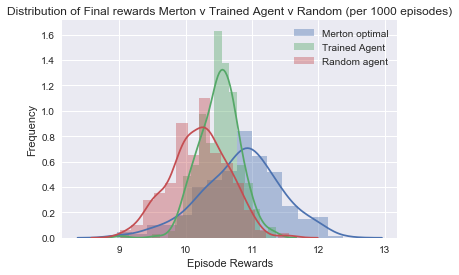

../lib/graphs.py:134: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


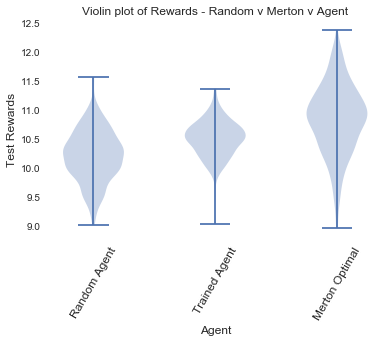

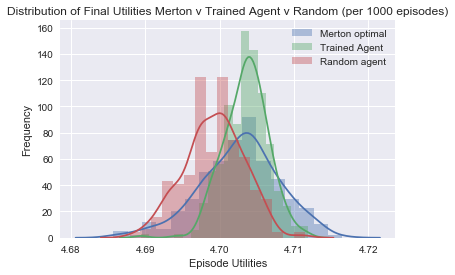

../lib/graphs.py:154: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


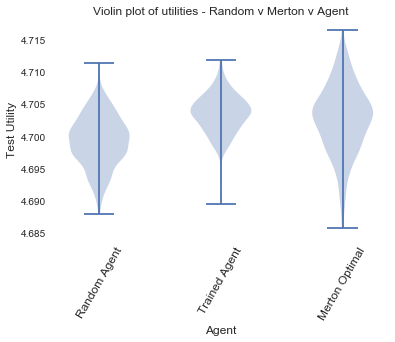

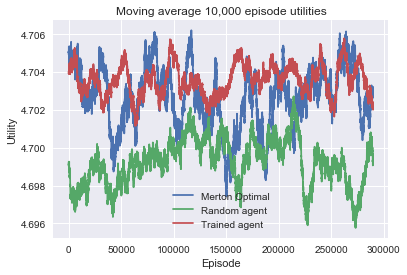

../lib/graphs.py:173: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


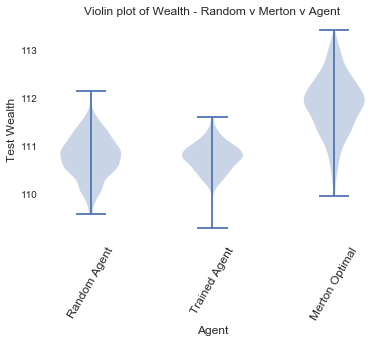

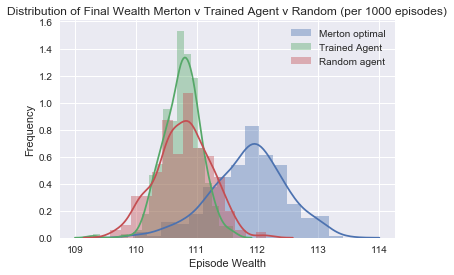

../lib/graphs.py:193: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


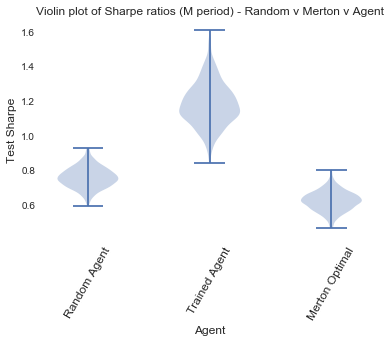

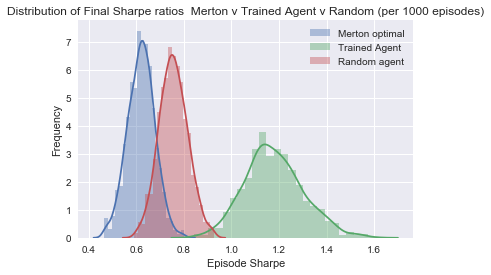

In [33]:
#Q = np.load('q_tables/prior_runs/best_q_so_far.npy')

#add in wealth episodes so we can look at return v volatility
#can look at wealth distribution as well as sharpe ratio

#Q = np.load('q_tables/model1epi1000000er0.npy')

utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
                                                            'Agent', q_values=Q, 
                                                            time_periods=time_periods, wealth=wealth)

#block_utilities_test = np.mean(np.array(utilities_test).reshape(1000,-1),0)
results = make_agent_graphs(rewards_test_best, rewards_test_rand, rewards_test,
                  utilities_test_best, utilities_test_rand, utilities_test,
                         wealth_test_rand, wealth_test_best, wealth_test)

#make_agent_graphs(block_utilities_test_best,block_utilities_test,
#                         block_utilities_test_rand, utilities_test_best,
#                         utilities_test_rand, utilities_test)